In [1]:
from dataclasses import dataclass
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from IPython.display import clear_output
import math
import inspect
import torch.version
from tqdm import trange

import torch
from torch import nn, Tensor
from torch.nn import functional as F
import torch.utils.data
import torchvision
torch.__version__

'2.4.0+cu121'

In [2]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Dataset

In [3]:
NUM_TIMESTEPS = 30
DATA_DIR = './data/VideoMNIST'
os.makedirs(DATA_DIR, exist_ok=True)

def shuffle(X:Tensor, y:Tensor): # (m, ...), (m, ...)
    assert X.shape[0] == y.shape[0]
    """returns X, y (but shuffled)"""
    idx = torch.randperm(X.shape[0])
    return X[idx], y[idx]

class VideoMNIST:
    def __init__(self, train:bool):
        mnist_dataset = torchvision.datasets.MNIST(root='./data', train=train, download=True)
        self.imgs = mnist_dataset.data/255.0
        self.labels = mnist_dataset.targets
        self.train = "train" if train else "val"

    def create_mnist_videos_as_tensors(self, num_videos:int, target_class:int, video_length:int):
        class_images = self.imgs[self.labels == target_class].tolist()
        
        if len(class_images) < video_length:
            raise ValueError("Not enough images in the dataset to create the videos")
        
        videos_tensor = []
        
        for _ in range(num_videos):
            video_frames = [random.choice(class_images) for _ in range(video_length)]
            video_tensor = np.array(video_frames).squeeze()[..., None] # (T, H, W, C=1)
            videos_tensor.append(video_tensor.tolist())
        assert len(videos_tensor) == num_videos
        return videos_tensor, [target_class for _ in range(num_videos)] # (B_per_class, T, H, W, C=1), (B_per_class,)
    
    def get_dataset(self, num_videos_per_class, video_length):
        xls, yls = [], []
        for i in range(10):
            x, y = self.create_mnist_videos_as_tensors(num_videos_per_class, i, video_length)
            xls.extend(x)
            yls.extend(y)
        
        images, labels = np.array(xls), np.array(yls)
        return images, labels
    
    def save(self, dir_path:str, num_videos_per_class:int, video_length:int):
        imgs, lbl = self.get_dataset(num_videos_per_class, video_length)
        np.save(os.path.join(dir_path, f"videos_{self.train}.npy"), imgs)
        np.save(os.path.join(dir_path, f"labels_{self.train}.npy"), lbl)
    
    @staticmethod
    def load_all(dir_path:str, channels_first:bool=True):
        train_imgs = np.load(os.path.join(dir_path, f"videos_train.npy")) # (B, T, H, W, C=1)
        train_lbl = np.load(os.path.join(dir_path, f"labels_train.npy"))

        val_imgs = np.load(os.path.join(dir_path, f"videos_val.npy")) # (B, T, H, W, C=1)
        val_lbl = np.load(os.path.join(dir_path, f"labels_val.npy"))

        if channels_first:
            train_imgs = train_imgs.transpose(0, 4, 1, 2, 3) # (B, C=1, T, H, W)
            val_imgs = val_imgs.transpose(0, 4, 1, 2, 3)     # (B, C=1, T, H, W)

        from torch import from_numpy
        train, val = (from_numpy(train_imgs), from_numpy(train_lbl)), (from_numpy(val_imgs), from_numpy(val_lbl))
        (X_train, y_train), (X_val, y_val) = shuffle(*train), shuffle(*val)
        return (X_train.float(), y_train), (X_val.float(), y_val)

# Example usage:
if len(os.listdir(DATA_DIR)) == 0:
    VideoMNIST(train=True).save(DATA_DIR, num_videos_per_class=10_000//10, video_length=NUM_TIMESTEPS)
    VideoMNIST(train=False).save(DATA_DIR, num_videos_per_class=2_000//10, video_length=NUM_TIMESTEPS)
(X_train, y_train), (X_val, y_val) = VideoMNIST.load_all(DATA_DIR, channels_first=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([10000, 1, 30, 28, 28]),
 torch.Size([10000]),
 torch.Size([2000, 1, 30, 28, 28]),
 torch.Size([2000]))

In [4]:
def play_video(video:Tensor, lbl:Tensor, channels_first:bool=True): # (C, T, H, W)
    if channels_first:
        video = video.permute(1, 2, 3, 0)
    for i in range(video.shape[0]):
        plt.imshow(video[i,..., 0], cmap='gray')
        plt.axis('off')
        plt.title(f"{lbl}")
        plt.show()
        clear_output(wait=True)
        time.sleep(0.1)

# play_video(X_train[25], y_train[25])

# ViViT
```python
in VIT:
    (B, H, W, C) -> (B, H//P, W//P, C*(P**2)) -> (B, N = H//P * W//P, d_model)

in ViVit:
    (B, T, H, W, C) -> (B, T//P, H//P, W//P, C*(P**3)) -> (B, N = T//P * H//P * W//P, d_model)
```

In [5]:
@dataclass
class config:
    in_channels:int = 1
    patch_size:int = 2
    H:int = 28
    W:int = 28
    T:int = NUM_TIMESTEPS
    N:int = H//patch_size * W//patch_size * T//patch_size # 28//2 * 28//2 * 30//2 = 2940
    assert N*patch_size**3 == H*W*T, f"{N}*{patch_size}**{3} != {H}*{W}*{T} => {N*patch_size**3} != {H*W*T}"


    d_model:int = 128
    num_heads:int = 8
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    num_layers:int = 5
    maxlen:int = N+1

    num_classes:int = 10
    batch_size:int = 32
    num_steps:int = 2000
    log_interval:int = 1

    weight_decay:float = 1e-2
    max_learning_rate:float = 1e-3
    min_learning_rate:float = 5e-4
    betas:tuple[int, int] = (0.9, 0.999)
    clipnorm:float = 1.0
    warmup_steps:int = 100
    eval_steps:int = 100
    eval_freq:int = 500

    dtype_type:str = 'bfloat16'
    device:torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Embed

In [6]:
class TubeletEmbed(nn.Module):
    """Get patch and embed it to a fixed sized vector at once"""
    def __init__(self, config:config):
        super().__init__()
        self.get_patch_and_project = nn.Conv3d(
            in_channels=config.in_channels,
            out_channels=config.d_model,
            kernel_size=config.patch_size,
            stride=config.patch_size, # P
            bias=False
        )

    def forward(self, x:Tensor): # (B, C, T, H, W)
        """```
        inputs        : (B, C_in, T_in, H_in, W_in)
        output of conv: (B, C_out, T_out = T_in//P, H_out=H_in//P, W_out=W_in//P)
        reshape to    : (B, N = T_in//P * H_in//P * W_in//P, d_model = C_out)
        ```"""
        x = self.get_patch_and_project(x).flatten(2) # (B, d_model, N = T//P * H//P * W//P)
        return x.permute(0, 2, 1) # (B, N, d_model)
    
emb = TubeletEmbed(config)(X_train[:2]) # (B=2, N, d_model)
assert emb.shape == (2, config.N, config.d_model), emb.shape

## Block

In [7]:
class SpatioTemporalAttentionBlock(nn.Module):
    def __init__(
        self,
        config:config,
    ):
        super().__init__()
        self.causal = False
        dff_in = int(4*config.d_model)
        self.norm1 = nn.LayerNorm(config.d_model, eps=1e-5)
        self.mha = nn.MultiheadAttention(
            embed_dim=config.d_model,
            num_heads=config.num_heads,
            batch_first=True,
            dropout=config.dropout_rate
        )

        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, dff_in),
            nn.GELU(approximate='tanh'),
            nn.Linear(dff_in, config.d_model),
            nn.Dropout(config.dropout_rate)
        )
        self.norm2 = nn.LayerNorm(config.d_model, eps=1e-5)
    
    def forward(self, x:Tensor):
        in_mha = self.norm1(x)
        z = x + self.mha(in_mha, in_mha, in_mha, is_causal=self.causal, need_weights=False)[0]
        y = z + self.ffn(self.norm2(z))
        return y # (B, T, d_model)
    
blck = SpatioTemporalAttentionBlock(config=config)(emb) # (B=2, N, d_model)
assert blck.shape == (2, config.N, config.d_model), blck.shape

In [8]:
# TODO
class FactorizedDotProductAttentionBlock(nn.Module):
    pass

## Model

In [9]:
class ViViT(nn.Module):
    def __init__(
        self, 
        block:nn.Module, 
        config:config
    ):
        super().__init__()
        self.tubelet_embed = TubeletEmbed(config)
        self.pos_embeddings = nn.Parameter(
            nn.Embedding(
                num_embeddings=config.maxlen, # N + 1
                embedding_dim=config.d_model
            )(torch.arange(config.maxlen)).unsqueeze(0)
        ) # (B=1, N, d_model)
        
        self.class_weight = nn.Parameter(
            nn.Linear(1, config.d_model, bias=False).weight.T
        ) # (1, d_model)
        self.blocks = nn.ModuleList([deepcopy(block) for _ in range(config.num_layers)])

        self.norm = nn.LayerNorm(config.d_model, eps=1e-5)
        self.mlp_head = nn.Linear(config.d_model, config.num_classes)

    def forward(self, x:Tensor): # (B, T, H, W, C)
        x = self.tubelet_embed(x) # (B, N, d_model)
        class_weight = self.class_weight.expand(x.shape[0], -1, -1)
        x = torch.concat([class_weight, x], dim=1) # (B, 1+N, d_model)
        x += self.pos_embeddings

        for block in self.blocks:
            x = block(x) # (B, 1+N, d_model)

        x = self.norm(x[:, 0, :]) # (B, d_model)
        x = self.mlp_head(x) # (B, num_classes)
        return x
    
    def configure_optimizers(
        self,
        weight_decay:float,
        learning_rate:float,
        betas:tuple[float, float],
        device_type:str
    ):
        params_dict = {pname:p for pname, p in self.named_parameters() if p.requires_grad}

        # all weights except layernorms and biases, embeddings and linears
        decay_params = [p for pname, p in params_dict.items() if p.dim() >= 2]
        # layernorms and biases
        non_decay_params = [p for pname, p in params_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": non_decay_params, "weight_decay": 0.}
        ]

        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        # other_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(
            params=optim_groups,
            lr=learning_rate,
            betas=betas,
            fused=False # getting error with fused=True
        )
        return optimizer
    
mod = ViViT(
    block=SpatioTemporalAttentionBlock(config), # stab
    config=config
).to(config.device)

mod(X_train[:2].to(config.device)) # (B=2, num_classes)
del mod

# Training

## Train Ops

In [10]:
class CosineDecayWithWarmup:
    def __init__(
        self,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        min_learning_rate:float
    ):
        self.warmup_steps = warmup_steps
        self.max_learning_rate = max_learning_rate
        self.decay_steps = decay_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # linear warmup for warmup_steps steps
        if step < self.warmup_steps:
            return self.max_learning_rate * step / self.warmup_steps
        # if it > decay_steps, return min learning rate
        if step > self.decay_steps:
            return self.min_learning_rate
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_learning_rate + coeff * (self.max_learning_rate - self.min_learning_rate)
    
class DataLoader:
    def __init__(self, dataset:tuple[Tensor, Tensor]):
        self.X, self.y = dataset

    def iter_batches(self, batch_size:int):
        while True:
            self.dataset = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(self.X, self.y),
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,
                drop_last=True
            )
            for X_batch, y_batch in self.dataset:
                yield X_batch.to(config.device), y_batch.to(config.device)

In [11]:
train_iterator = iter(DataLoader((X_train, y_train)).iter_batches(config.batch_size))
val_iterator = iter(DataLoader((X_val, y_val)).iter_batches(config.batch_size))

get_lr = CosineDecayWithWarmup(
    warmup_steps=config.warmup_steps,
    max_learning_rate=config.max_learning_rate,
    decay_steps=config.num_steps,
    min_learning_rate=config.min_learning_rate
)

stab_model = ViViT(
    block=SpatioTemporalAttentionBlock(config), # stab
    config=config
).to(config.device)
stab_model.compile()

optimizer = stab_model.configure_optimizers(
    weight_decay=config.weight_decay,
    learning_rate=config.max_learning_rate,
    betas=config.betas,
    device_type=config.device.type
)

ctx = torch.autocast(
        device_type=config.device.type,
        dtype={"bfloat16": torch.bfloat16,
               "float32" : torch.float32}[config.dtype_type]
    )

@torch.no_grad()
def evaluate(model:nn.Module):
    model.eval()
    mean_losses, mean_metrics = [], []
    for iterator in [train_iterator, val_iterator]:
        losses = torch.empty((config.eval_steps,))
        metrics = torch.empty_like(losses)
        for i in trange(config.eval_steps):
            X_batch, y_batch = next(iterator)
            with ctx:
                y_pred = model(X_batch)
            loss = F.cross_entropy(y_pred, y_batch)
            losses[i] = loss.item()
            metrics[i] = (y_pred.argmax(1) == y_batch).float().mean()
        mean_losses.append(losses.mean())
        mean_metrics.append(metrics.mean())
    model.train()

    return mean_losses, mean_metrics

print(sum(p.numel() for p in stab_model.parameters() if p.requires_grad)/1e6, "Million Parameters\n")

1.370506 Million Parameters



In [ ]:
def train(model:nn.Module):
    t0 = time.time()
    losses, accuracies = [], []
    for step in range(0, config.num_steps):
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        if (step % config.eval_freq == 0 and step > 0) or step == config.num_steps-1:
            mean_losses, mean_accuracies = evaluate(model)
            print(
                    f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                    f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
                )

        optimizer.zero_grad(set_to_none=True)
        X_batch, y_batch = next(train_iterator)
        with ctx:
            y_pred = model(X_batch) # (B, num_classes)
        loss = F.cross_entropy(y_pred, y_batch)
        loss.backward()
        if config.clipnorm is not None:
            norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clipnorm, error_if_nonfinite=True)
        optimizer.step()

        t1 = time.time()
        dt = t1-t0
        t0 = t1
        if step % config.log_interval == 0:
            lossf, acc = loss.item(), (y_pred.argmax(1) == y_batch).float().mean().item()
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || Accuracy: {acc:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
                f"| Norm: {norm:.4f} |" if config.clipnorm is not None else ""
            )
            losses.append(lossf); accuracies.append(acc)
    return losses, accuracies

losses, accuracies = train()

| Training Loss: 0.0186 || Training Accuracy: 0.9944 || Validation Loss: 0.0281 || Validation Accuracy: 0.9919 |

# Predictions

In [13]:
def show(idx:int):
    stab_model.eval()
    X_batch, y_batch = X_val[idx:idx+1], y_val[idx:idx+1]
    with torch.no_grad():
        y_pred = stab_model(X_batch.to(config.device))
    pred, true = y_pred.argmax(1).item(), y_batch.item()
    print(f"| True: {true} | Prediction: {pred} |")
    time.sleep(0.5)
    play_video(X_batch[0], y_batch[0])
    if pred != true:
        print("Model made a mistake".upper())

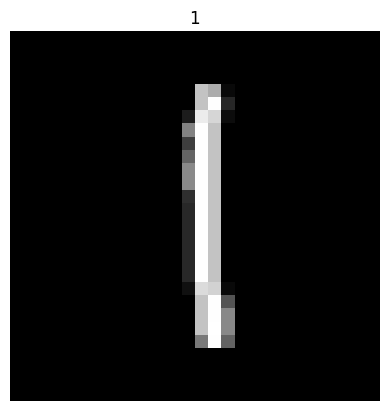

In [14]:
for _ in range(5):
    show(random.randint(0, len(X_val)-1))
# `play_video` clears the output, any better way to play video (ipython display doesnt work for me)?